## Dependencies

In [ ]:
!pip install gdown
!pip install imbalanced-learn
!pip install xgboost
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import gdown
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# Data Source

[Kaggle - Churn Modelling Calssification Data Set](https://www.kaggle.com/shrutimechlearn/churn-modelling)

This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

It consists of 10,000 records  with demographic and bank history information from customers from three countries, France, Germany and Spain,



# Exploratory Analysis

### Read the CSV and Perform Basic Data Cleaning

In [ ]:
# Download the file from Google Drive using gdown
url = "https://drive.google.com/file/d/1FZh6kkZKGrf_TT9dHvtuVE5EJIL6BdSC/view?usp=sharing"
output = "data.csv"

# Get the file ID from the URL
file_id = url.split('/')[-2]

# Construct the download URL with the file ID
download_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(download_url, output, quiet=False) # Download the file to 'data.csv'

# Now read the downloaded CSV into a pandas DataFrame
# adding sep=',' in case ';' is the delimiter in the file
df = pd.read_csv("data.csv", sep=',')

Downloading...
From: https://drive.google.com/uc?id=1FZh6kkZKGrf_TT9dHvtuVE5EJIL6BdSC
To: /content/data.csv
100%|██████████| 675k/675k [00:00<00:00, 60.7MB/s]


In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# # Load the dataset if above method doesn't work
# df = pd.read_csv("/content/Churn_Modelling.csv")
# print(f"Dataframe dimensions: {df.shape}")

## EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are no "nulls" in our dataframe.

In [ ]:
# List number of unique customer IDs
df.CustomerId.nunique()

10000

All Customer IDs are unique --> that also means no duplicates

In [ ]:
df.duplicated().sum()

0

#### Unused Features

To make dataframe easily readable we will drop features not needed for machine learning:

* RowNumber
* CustomerId
* Surname

In [ ]:
# Drop unused features
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
print(f"Dataframe dimensions: {df.shape}")
df.head()

Dataframe dimensions: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Distributions of Numeric Features

#### Plotting Histogram grid

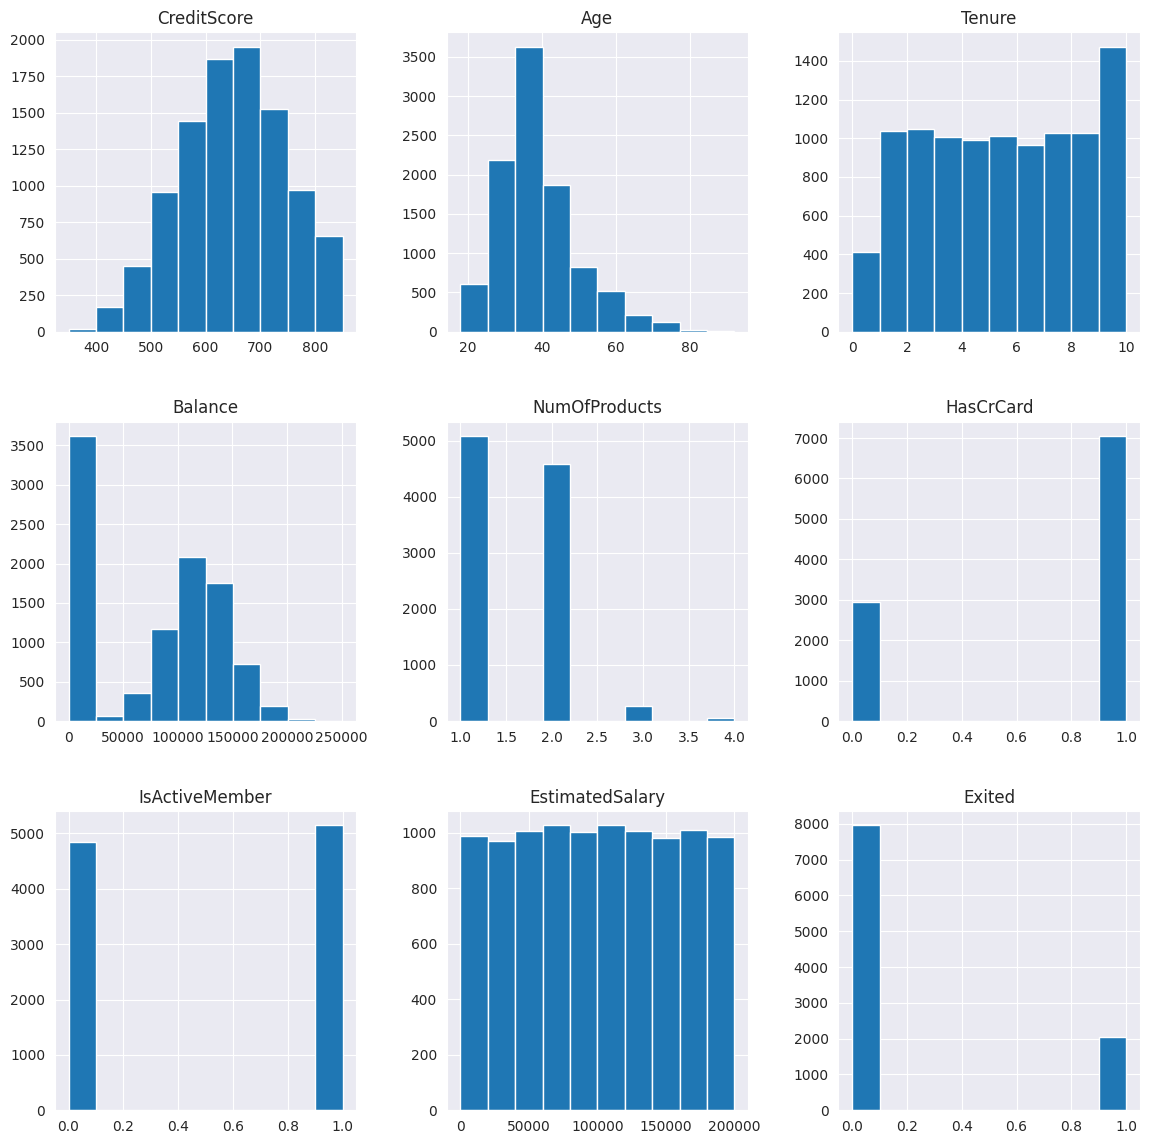

In [ ]:
# Plot histogram grid
df.hist(figsize=(14,14))

plt.show()

#### Summary statistics for the numeric features

In [ ]:
# Summarize numerical features
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


From the summary statistics and the histograms we can conclude that all features look OK. We do not see any extreme values for any feature.

### Distributions of Categorical Features

In [ ]:
# Summarize categorical features
df.describe(include=['object'])

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


This shows us the number of unique classes for each feature. For example, there are more males (5457) than females. And France is most common of 3 geographies in our dataframe. There are no sparse classes.

Let's visualize this information.

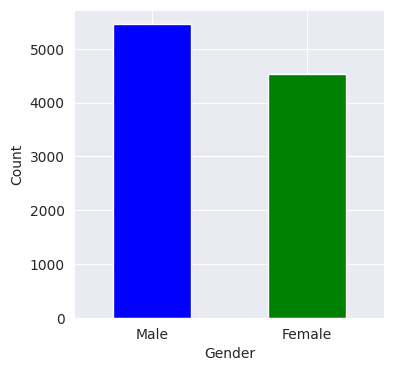

Counter({'Female': 4543, 'Male': 5457})

In [ ]:
# Bar plot for "Gender"
plt.figure(figsize=(4,4))
df['Gender'].value_counts().plot.bar(color=['b', 'g'])
plt.ylabel('Count')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.show()

# Display count of each class
Counter(df.Gender)

In our data sample there are more males than females.

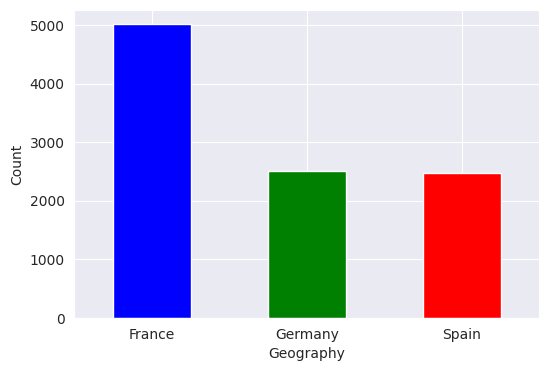

Counter({'France': 5014, 'Spain': 2477, 'Germany': 2509})

In [ ]:
# Bar plot for "Geography"
plt.figure(figsize=(6,4))
df['Geography'].value_counts().plot.bar(color=['b', 'g', 'r'])
plt.ylabel('Count')
plt.xlabel('Geography')
plt.xticks(rotation=0)
plt.show()

# Display count of each class
Counter(df.Geography)

:Majority of customers are from France, about 50%, and from Germany and Spain around 25% each.

### Churn Segmentation by Gender

In [ ]:
# Segment "Exited" by gender and display the frequency and percentage within each class
grouped = df.groupby('Gender')['Exited'].agg(Count='value_counts')
grouped

Count
Gender Exited       
Female 0        3404
       1        1139
Male   0        4559
       1         898

In [ ]:
# Reorganize dataframe for plotting count
dfgc = grouped
dfgc = dfgc.pivot_table(values='Count', index='Gender', columns=['Exited'])
dfgc

Exited,0,1
Gender,,
Female,3404.0,1139.0
Male,4559.0,898.0


In [ ]:
# Calculate percentage within each class
dfgp = grouped.groupby(level=[0]).apply(lambda g: round(g * 100 / g.sum(), 2))
dfgp.rename(columns={'Count': 'Percentage'}, inplace=True)
dfgp

Percentage
Gender Gender Exited            
Female Female 0            74.93
              1            25.07
Male   Male   0            83.54
              1            16.46

In [ ]:
# Reorganize dataframe for plotting percentage
dfgp = dfgp.pivot_table(values='Percentage', index='Gender', columns=['Exited'])
dfgp

Exited,0,1
Gender,,
Female,74.93,25.07
Male,83.54,16.46


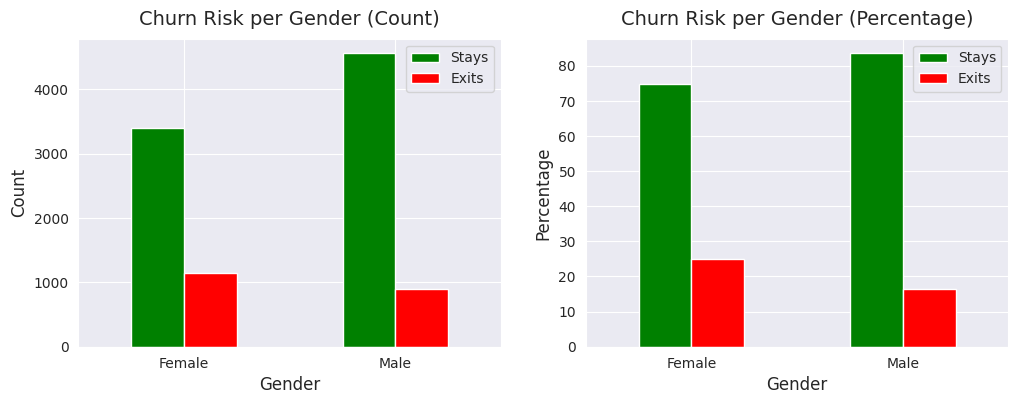

In [ ]:
# Churn distribution by gender, count + percentage

labels= ['Stays', 'Exits']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

dfgc.plot(kind='bar',
          color=['g', 'r'],
          rot=0,
          ax=ax1)
ax1.legend(labels)
ax1.set_title('Churn Risk per Gender (Count)', fontsize=14, pad=10)
ax1.set_ylabel('Count',size=12)
ax1.set_xlabel('Gender', size=12)


dfgp.plot(kind='bar',
          color=['g', 'r'],
          rot=0,
          ax=ax2)
ax2.legend(labels)
ax2.set_title('Churn Risk per Gender (Percentage)', fontsize=14, pad=10)
ax2.set_ylabel('Percentage',size=12)
ax2.set_xlabel('Gender', size=12)

plt.show()



> Add blockquote


In percentage females are more likely to leave the bank; 25% comparing to males, 16%.

### Churn Segmentation by Geography

In [ ]:
# Segment "Exited" by geography and display the frequency and percentage within each class
grouped = df.groupby('Geography')['Exited'].agg(Count='value_counts')
grouped

Count
Geography Exited       
France    0        4204
          1         810
Germany   0        1695
          1         814
Spain     0        2064
          1         413

In [ ]:
# Reorganize dataframe for plotting count
dfgeoc = grouped
dfgeoc = dfgeoc.pivot_table(values='Count', index='Geography', columns=['Exited'])
dfgeoc

Exited,0,1
Geography,,
France,4204.0,810.0
Germany,1695.0,814.0
Spain,2064.0,413.0


In [ ]:
# Calculate percentage within each class
dfgeop = grouped.groupby(level=[0]).apply(lambda g: round(g * 100 / g.sum(), 2))
dfgeop.rename(columns={'Count': 'Percentage'}, inplace=True)
dfgeop

Percentage
Geography Geography Exited            
France    France    0            83.85
                    1            16.15
Germany   Germany   0            67.56
                    1            32.44
Spain     Spain     0            83.33
                    1            16.67

In [ ]:
# Reorganize dataframe for plotting percentage
dfgeop = dfgeop.pivot_table(values='Percentage', index='Geography', columns=['Exited'])
dfgeop

Exited,0,1
Geography,,
France,83.85,16.15
Germany,67.56,32.44
Spain,83.33,16.67


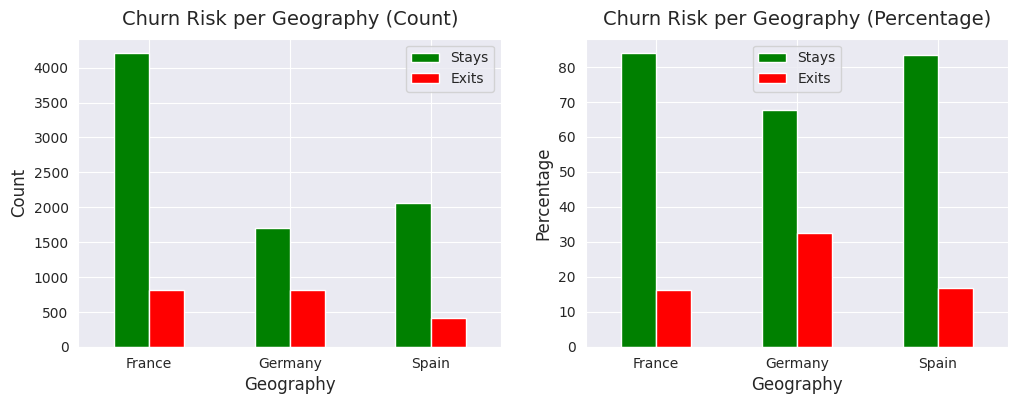

In [ ]:
# Churn distribution by geography, count + percentage

labels= ['Stays', 'Exits']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

dfgeoc.plot(kind='bar',
          color=['g', 'r'],
          rot=0,
          ax=ax1)
ax1.legend(labels)
ax1.set_title('Churn Risk per Geography (Count)', fontsize=14, pad=10)
ax1.set_ylabel('Count',size=12)
ax1.set_xlabel('Geography', size=12)


dfgeop.plot(kind='bar',
          color=['g', 'r'],
          rot=0,
          ax=ax2)
ax2.legend(labels)
ax2.set_title('Churn Risk per Geography (Percentage)', fontsize=14, pad=10)
ax2.set_ylabel('Percentage',size=12)
ax2.set_xlabel('Geography', size=12)

plt.show()


The smallest number of customers are from Germany but it looks that they are most likely to leave the bank. Almost one third of German customers in our sample left the bank.

## Correlations

In [ ]:
# Calculate correlations between numeric features
numeric_df = df.select_dtypes(include=['number'])
correlations = numeric_df.corr()
# correlations = df.corr()

# sort features in order of their correlation with "Exited"
sort_corr_cols = correlations.Exited.sort_values(ascending=False).keys()
sort_corr = correlations.loc[sort_corr_cols,sort_corr_cols]
sort_corr

,Exited,Age,Balance,EstimatedSalary,HasCrCard,Tenure,CreditScore,NumOfProducts,IsActiveMember
Exited,1.000000,0.285323,0.118533,0.012097,-0.007138,-0.014001,-0.027094,-0.047820,-0.156128
Age,0.285323,1.000000,0.028308,-0.007201,-0.011721,-0.009997,-0.003965,-0.030680,0.085472
Balance,0.118533,0.028308,1.000000,0.012797,-0.014858,-0.012254,0.006268,-0.304180,-0.010084
EstimatedSalary,0.012097,-0.007201,0.012797,1.000000,-0.009933,0.007784,-0.001384,0.014204,-0.011421
HasCrCard,-0.007138,-0.011721,-0.014858,-0.009933,1.000000,0.022583,-0.005458,0.003183,-0.011866
Tenure,-0.014001,-0.009997,-0.012254,0.007784,0.022583,1.000000,0.000842,0.013444,-0.028362
CreditScore,-0.027094,-0.003965,0.006268,-0.001384,-0.005458,0.000842,1.000000,0.012238,0.025651
NumOfProducts,-0.047820,-0.030680,-0.304180,0.014204,0.003183,0.013444,0.012238,1.000000,0.009612
IsActiveMember,-0.156128,0.085472,-0.010084,-0.011421,-0.011866,-0.028362,0.025651,0.009612,1.000000


Let's use Seaborn's .heatmap() function to visualize the correlation grid.

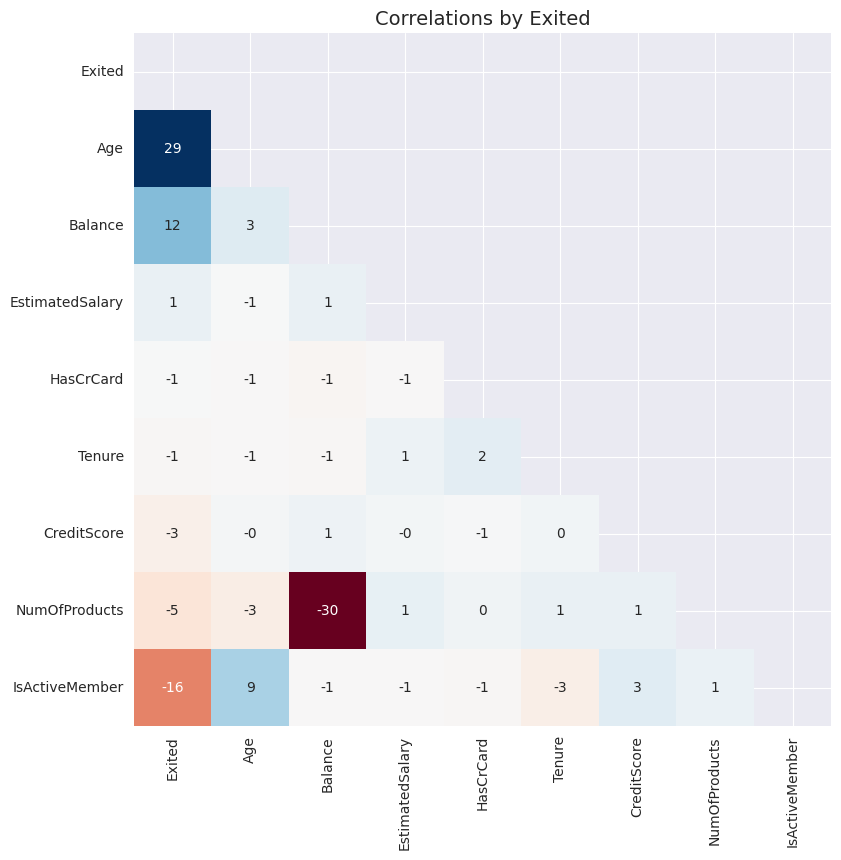

In [ ]:
# Generate a mask for the upper triangle
corr_mask = np.zeros_like(correlations)
corr_mask[np.triu_indices_from(corr_mask)] = 1

# Make the figsize 9x9
plt.figure(figsize=(9,9))

# Plot heatmap of annotated correlations; change background to white
##with sns.axes_style('white'):
sns.heatmap(sort_corr*100,
                cmap='RdBu',
                annot=True,
                fmt='.0f',
                mask=corr_mask,
                cbar=False)

plt.title('Correlations by Exited', fontsize=14)
plt.yticks(rotation=0)
plt.show()

Very weak correlations in general. Only weak positive correlation with age, very weak positive correlation with balance, and very weak negative correlations with number of products and membership.

## Pairplot

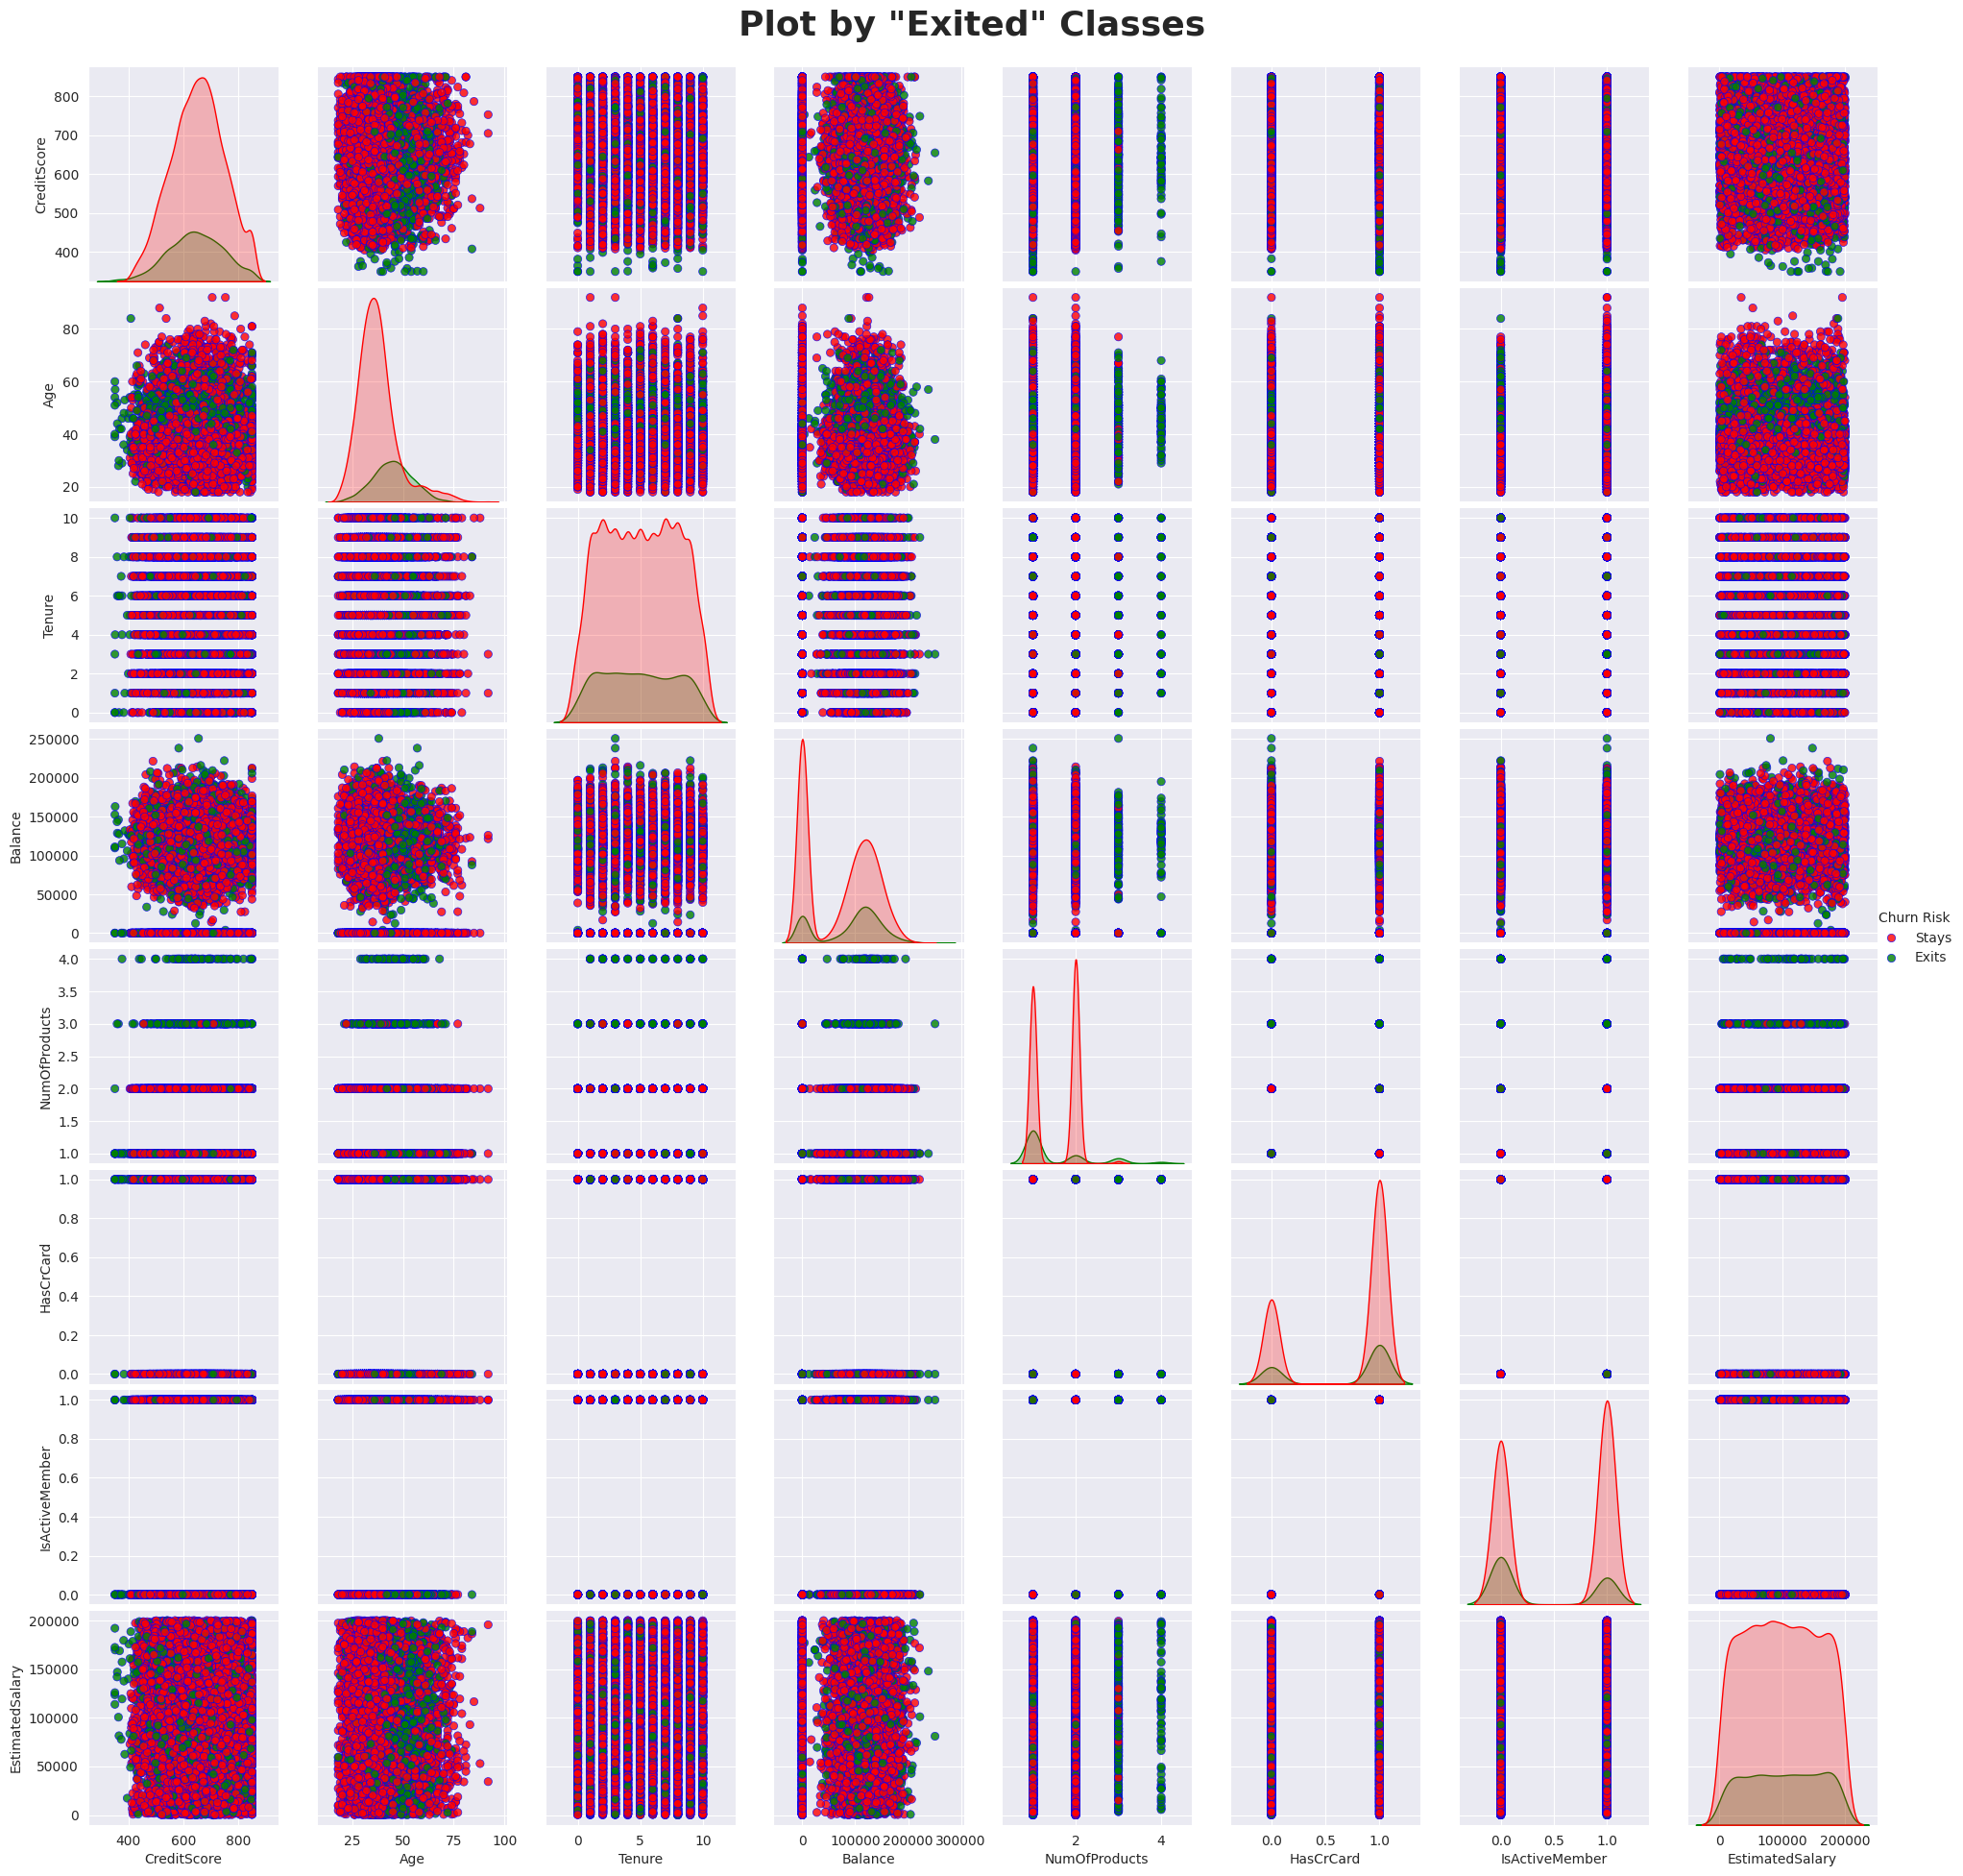

In [ ]:
# Plot Seaborn's pairplot
g = sns.pairplot(df, hue='Exited',
                 palette={1 : 'green',
                          0 : 'red'},
                 plot_kws={'alpha' : 0.8, 'edgecolor' : 'b', 'linewidth' : 0.5})

fig = g.fig
fig.subplots_adjust(top=0.95, wspace=0.2)
fig.suptitle('Plot by "Exited" Classes',
             fontsize=26,
             fontweight='bold')


# Update the legend
new_title = 'Churn Risk'
g._legend.set_title(new_title)
# replace labels
new_labels = ['Stays', 'Exits']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

plt.show()

The *density plots* on the diagonal make it easier to compare these distributions. We can notice that only few features have slightly different distributions. For example, from the density plot for <code style="color:steelblue">Age</code>, it could be seen that older people have slightly higher tendecy to leave the bank.

Let’s reduce the clutter by plotting only four features: <code style="color:steelblue">Age</code>, <code style="color:steelblue">IsActiveMember</code>, <code style="color:steelblue">NumOfProducts</code> and <code style="color:steelblue">Balance</code>.

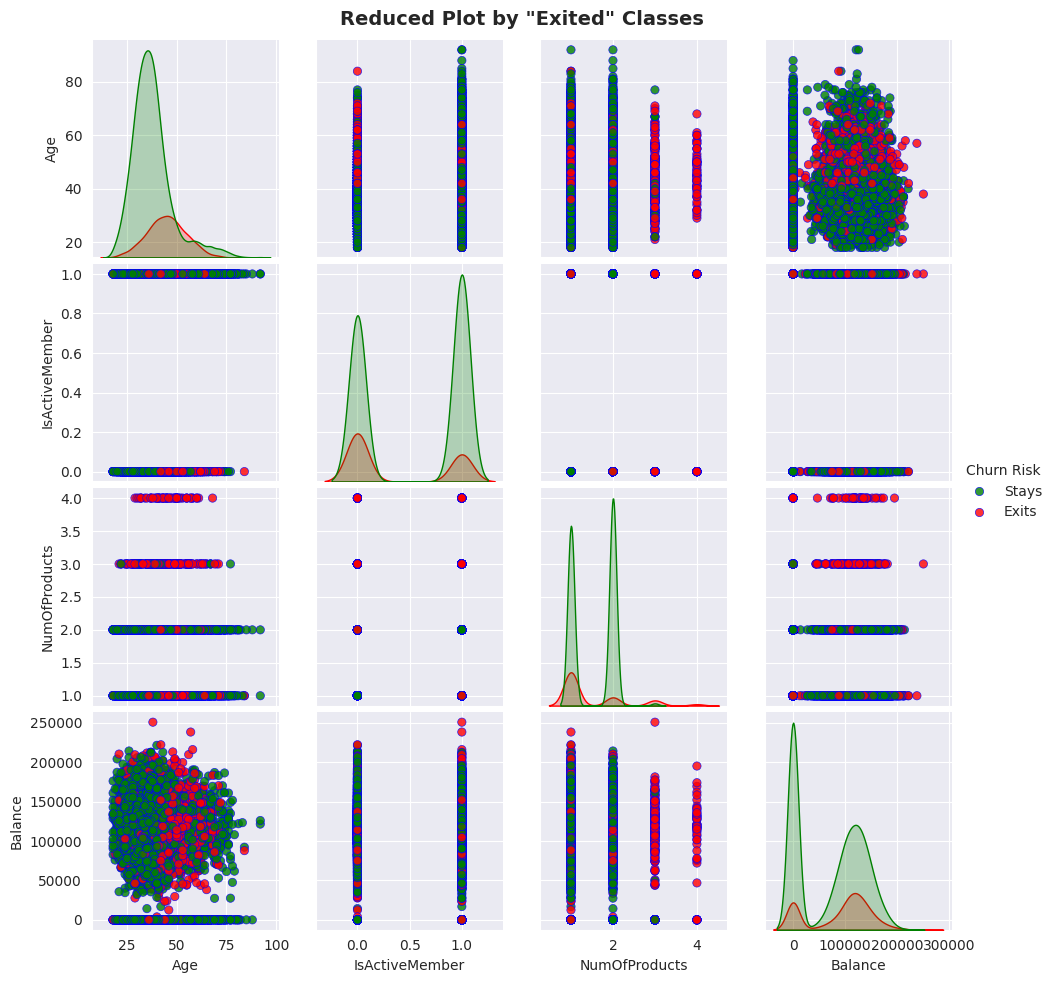

In [ ]:
# Plot Seaborn's pairplot
g = sns.pairplot(df, hue='Exited',
                 vars=['Age', 'IsActiveMember', 'NumOfProducts', 'Balance'], # reduce to less features
                 palette={0 : 'green',
                          1 : 'red'},
                 plot_kws={'alpha' : 0.8, 'edgecolor' : 'b', 'linewidth' : 0.5})

fig = g.fig
fig.subplots_adjust(top=0.95, wspace=0.2)
fig.suptitle('Reduced Plot by "Exited" Classes',
             fontsize=14,
             fontweight='bold')

# Update the legend
new_title = 'Churn Risk'
g._legend.set_title(new_title)
# replace labels
new_labels = ['Stays', 'Exits']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

plt.show()

From density plots we can see that older customers and customer with more products more often leaving the bank.

## Violin Plots

<ipython-input-29-75ed8d04e8c1>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=churn,
<ipython-input-29-75ed8d04e8c1>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=churn,
<ipython-input-29-75ed8d04e8c1>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=churn,
<ipython-input-29-75ed8d04e8c1>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=churn,


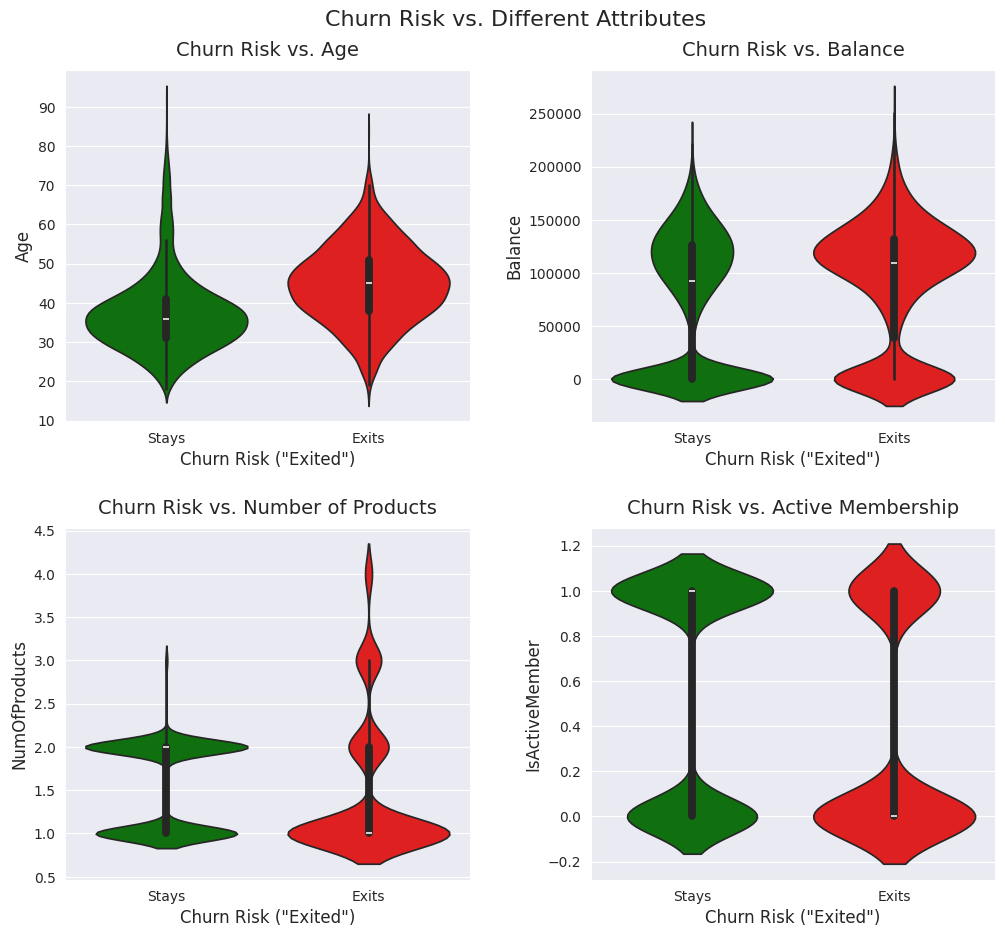

In [ ]:
# Segment age by Exited and plot distributions
#  “categorical” variable Exited is a numeric
#  for plotting purposes only we will change it to real categorical variable

# Define palette
my_pal = {'Stays': 'green', 'Exits': 'red'}
# Convert to categorical
hr = {0: 'Stays', 1: 'Exits'}
churn = df['Exited'].map(hr)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Churn Risk vs. Different Attributes', fontsize=16)
fig.subplots_adjust(top=0.92, wspace=0.3, hspace=0.3)

sns.violinplot(x=churn,
               y=df['Age'],
               order=['Stays', 'Exits'],
               palette=my_pal,
               ax=ax1)

ax1.set_title('Churn Risk vs. Age', fontsize=14, pad=10)
ax1.set_ylabel('Age',size=12)
ax1.set_xlabel('Churn Risk ("Exited")', size=12)

sns.violinplot(x=churn,
               y=df['Balance'],
               order=['Stays', 'Exits'],
               palette=my_pal,
               ax=ax2)

ax2.set_title('Churn Risk vs. Balance', fontsize=14, pad=10)
ax2.set_ylabel('Balance',size=12)
ax2.set_xlabel('Churn Risk ("Exited")', size=12)

sns.violinplot(x=churn,
               y=df['NumOfProducts'],
               order=['Stays', 'Exits'],
               palette=my_pal,
               ax=ax3)

ax3.set_title('Churn Risk vs. Number of Products', fontsize=14, pad=10)
ax3.set_ylabel('NumOfProducts',size=12)
ax3.set_xlabel('Churn Risk ("Exited")', size=12)

sns.violinplot(x=churn,
               y=df['IsActiveMember'],
               order=['Stays', 'Exits'],
               palette=my_pal,
               ax=ax4)

ax4.set_title('Churn Risk vs. Active Membership', fontsize=14, pad=10)
ax4.set_ylabel('IsActiveMember',size=12)
ax4.set_xlabel('Churn Risk ("Exited")', size=12)
plt.show()

Violin plots are confirming the earlier statement that older customers and customer with more products are more likely to leave the bank.

### Distributions of the Target Feature

In [ ]:
# Define our target variable
y = df.Exited

In [ ]:
y.shape

(10000,)

Let's define a small helper funtcion which displays count and percentage per class of the target feature.

In [ ]:
# Function to display count and percentage per class of target feature
def class_count(a):
    counter=Counter(a)
    kv=[list(counter.keys()),list(counter.values())]
    dff = pd.DataFrame(np.array(kv).T, columns=['Exited','Count'])
    dff['Count'] = dff['Count'].astype('int64')
    dff['%'] = round(dff['Count'] / a.shape[0] * 100, 2)
    return dff.sort_values('Count',ascending=False)

In [ ]:
# Let's use the function
dfcc = class_count(y)
dfcc

,Exited,Count,%
1,0,7963,79.63
0,1,2037,20.37


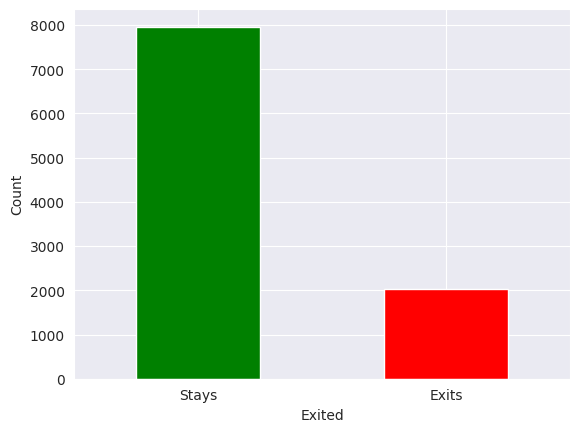

In [ ]:
# Plot distribution of target variable, Exited column

labels=['Stays', 'Exits']
dfcc.plot.bar(x='Exited', y='Count', color=['g', 'r'], legend=False)
plt.xticks(dfcc['Exited'], labels, rotation=0)
plt.ylabel('Count')
plt.show()

We can see that our dataset is imbalanced. The majority class, "Stays" (0), has around 80% data points and the minority class, "Exits" (1), has around 20% datapoints.

To address this, in our machine learning algorithms we will use SMOTE (Synthetic Minority Over-sampling Technique).

## Encoding and Scaling required Columns

In [ ]:
# using onehot encoding to geogaphy and gender column in the dataset

# Create dummy variables for Geography and Gender
df = pd.get_dummies(df, columns=['Geography', 'Gender'], prefix=['Geography', 'Gender'])

# Display the updated dataframe
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,True,False,False,True,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,True,False,False,True,False
3,699,39,1,0.00,2,0,0,93826.63,0,True,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True,True,False


In [ ]:
# using minmax scalar on balance, age and creditscore column in df
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the specified columns
df[['Balance', 'Age', 'CreditScore']] = scaler.fit_transform(df[['Balance', 'Age', 'CreditScore']])


In [ ]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.538,0.324324,2,0.000000,1,1,1,101348.88,1,True,False,False,True,False
1,0.516,0.310811,1,0.334031,1,0,1,112542.58,0,False,False,True,True,False
2,0.304,0.324324,8,0.636357,3,1,0,113931.57,1,True,False,False,True,False
3,0.698,0.283784,1,0.000000,2,0,0,93826.63,0,True,False,False,True,False
4,1.000,0.337838,2,0.500246,1,1,1,79084.10,0,False,False,True,True,False


In [ ]:
# use minmax scalar on estimated salary column in df

# Assuming 'EstimatedSalary' is the column you want to scale
scaler = MinMaxScaler()

# Fit and transform the 'EstimatedSalary' column
df['EstimatedSalary'] = scaler.fit_transform(df[['EstimatedSalary']])

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.538,0.324324,2,0.000000,1,1,1,0.506735,1,True,False,False,True,False
1,0.516,0.310811,1,0.334031,1,0,1,0.562709,0,False,False,True,True,False
2,0.304,0.324324,8,0.636357,3,1,0,0.569654,1,True,False,False,True,False
3,0.698,0.283784,1,0.000000,2,0,0,0.469120,0,True,False,False,True,False
4,1.000,0.337838,2,0.500246,1,1,1,0.395400,0,False,False,True,True,False


In [ ]:
# change True, False with 0,1 in the columns Geography_France	Geography_Germany	Geography_Spain	Gender_Female	Gender_Male in df

# Replace True/False with 0/1 in specified columns
df[['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']] = \
    df[['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']].astype(int)

In [ ]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.538,0.324324,2,0.000000,1,1,1,0.506735,1,1,0,0,1,0
1,0.516,0.310811,1,0.334031,1,0,1,0.562709,0,0,0,1,1,0
2,0.304,0.324324,8,0.636357,3,1,0,0.569654,1,1,0,0,1,0
3,0.698,0.283784,1,0.000000,2,0,0,0.469120,0,1,0,0,1,0
4,1.000,0.337838,2,0.500246,1,1,1,0.395400,0,0,0,1,1,0


In [ ]:
# use minmax scalar on tensure and number of product

# Assuming 'Tenure' and 'NumOfProducts' are the columns you want to scale
scaler = MinMaxScaler()

# Fit and transform the specified columns
df[['Tenure', 'NumOfProducts']] = scaler.fit_transform(df[['Tenure', 'NumOfProducts']])

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.538,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,1,0,0,1,0
1,0.516,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0,0,1,1,0
2,0.304,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1,0,0,1,0
3,0.698,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1,0,0,1,0
4,1.000,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0,0,1,1,0


In [ ]:
# use SMOTE to fix inbalance in Exited columns were 0 is 79.63% and 1 is the remaining

# Separate features and target variable
X = df.drop('Exited', axis=1)
y = df['Exited']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new balanced DataFrame
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Print the class distribution after SMOTE
print(df_resampled['Exited'].value_counts())

Exited
1    7963
0    7963
Name: count, dtype: int64


In [ ]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.538,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,1,0,0,1,0
1,0.516,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0,0,1,1,0
2,0.304,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,1,0,0,1,0
3,0.698,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,1,0,0,1,0
4,1.000,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0,0,1,1,0


## Model Building

In [ ]:
X = df_resampled.drop('Exited', axis=1)
y = df_resampled['Exited']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (12740, 13)
X_test shape: (3186, 13)
y_train shape: (12740,)
y_test shape: (3186,)


# Decision Tree

In [ ]:
# using Decision tree to predicted the exited column and get the best param for the hyper parameter tuning

# Create a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid,
                           scoring='recall', cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_


In [ ]:
# Make predictions on the test set
y_pred = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.8411801632140615
Precision: 0.8205756276791182
Recall: 0.8628461043142305
F1-Score: 0.8411801632140615


In [ ]:
# print first 10 values of y_test and y_pred in form of a list
print("-----------------------------------------------------------------------------------")
print(f"First 10 values of y_test: {y_test.tolist()[:10]}")
print(f"First 10 values of y_pred: {y_pred.tolist()[:10]}")

-----------------------------------------------------------------------------------
First 10 values of y_test: [0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
First 10 values of y_pred: [0, 1, 0, 1, 0, 0, 1, 1, 1, 0]


Confusion Matrix:
[[1340  293]
 [ 213 1340]]


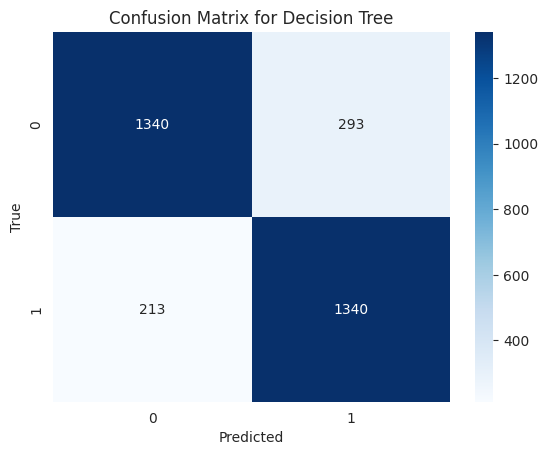

In [ ]:
# confusion matrix for the DT prediction
# Assuming y_test and y_pred are already defined from your code

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# You can also visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

## Random Forest Classifier

In [ ]:
# using random forest to predicted the exited column and get the best param for the hyper parameter tuning

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           scoring='recall', cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [ ]:
# Make predictions on the test set
y_pred = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9001883239171374
Precision: 0.8945686900958466
Recall: 0.901481004507405
F1-Score: 0.8980115458627326


In [ ]:
# print first 10 values of y_test and y_pred in form of a list
print("-----------------------------------------------------------------------------------")
print(f"First 10 values of y_test: {y_test.tolist()[:10]}")
print(f"First 10 values of y_pred: {y_pred.tolist()[:10]}")

-----------------------------------------------------------------------------------
First 10 values of y_test: [0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
First 10 values of y_pred: [0, 1, 0, 1, 0, 0, 1, 1, 0, 0]


Confusion Matrix:
[[1468  165]
 [ 153 1400]]


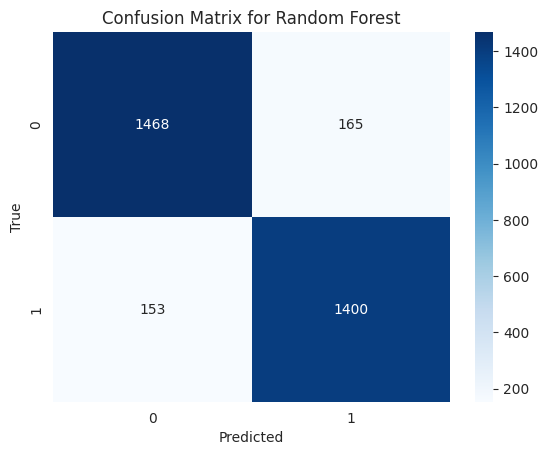

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# You can also visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest')
plt.show()

## Linear Regression

In [ ]:
# using Linear regression classifier to predicted the exited column and get the best param for the hyper parameter tuning

# Create a logistic Regression model
lr_model = LogisticRegression()

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.29252981795354677


In [ ]:
# calculate accuracy,recall,f1 score, precision for the linear regression model

# Assuming y_test and y_pred are already defined from your code
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Convert predicted probabilities to binary labels (e.g., using a threshold of 0.5)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# print first 10 values of y_test and y_pred in form of a list
print("-----------------------------------------------------------------------------------")
print(f"First 10 values of y_test: {y_test.tolist()[:10]}")
print(f"First 10 values of y_pred: {y_pred.tolist()[:10]}")

Accuracy: 0.7074701820464532
Precision: 0.6984025559105431
Recall: 0.7037990985189955
F1-Score: 0.7010904425914047
-----------------------------------------------------------------------------------
First 10 values of y_test: [0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
First 10 values of y_pred: [0, 1, 0, 1, 1, 0, 1, 1, 0, 0]


Confusion Matrix:
[[1161  472]
 [ 460 1093]]


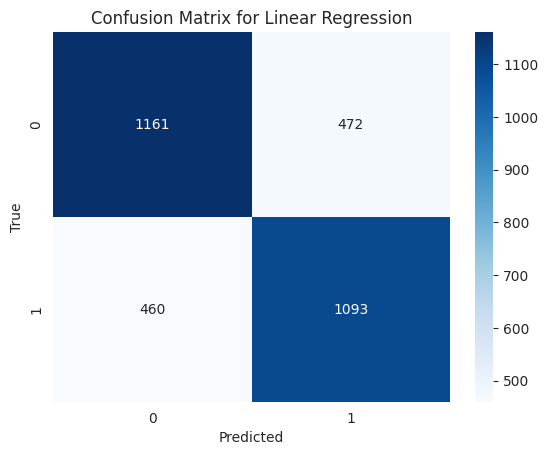

In [ ]:
# plot confusion matrix for linear regression

# Assuming y_test and y_pred_binary are already defined from your code

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# You can also visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Linear Regression')
plt.show()

## Support Vector Classifier (SVC)

In [ ]:
# using SVC to predicted the exited column and get the best param for the hyper parameter tuning

# Create an SVC model
svc_model = SVC(random_state=42)

# Define hyperparameters to tune

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid,
                           scoring='recall', cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [ ]:
# Make predictions on the test set
y_pred = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

In [ ]:
# print first 10 values of y_test and y_pred in form of a list
print("-----------------------------------------------------------------------------------")
print(f"First 10 values of y_test: {y_test.tolist()[:10]}")
print(f"First 10 values of y_pred: {y_pred.tolist()[:10]}")

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# You can also visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVC')
plt.show()

## XGBoost

In [ ]:
# using XGBoost to predicted the exited column and get the best param for the hyper parameter tuning
# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Define hyperparameters to tune

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}


# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='recall', cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [ ]:
# Make predictions on the test set
y_pred = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 0.9061519146264909
Precision: 0.9208053691275168
Recall: 0.8834513844172569
F1-Score: 0.9017417022674992


In [ ]:
# print first 10 values of y_test and y_pred in form of a list
print("-----------------------------------------------------------------------------------")
print(f"First 10 values of y_test: {y_test.tolist()[:10]}")
print(f"First 10 values of y_pred: {y_pred.tolist()[:10]}")

-----------------------------------------------------------------------------------
First 10 values of y_test: [0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
First 10 values of y_pred: [0, 1, 0, 1, 0, 0, 0, 1, 0, 0]


Confusion Matrix:
[[1515  118]
 [ 181 1372]]


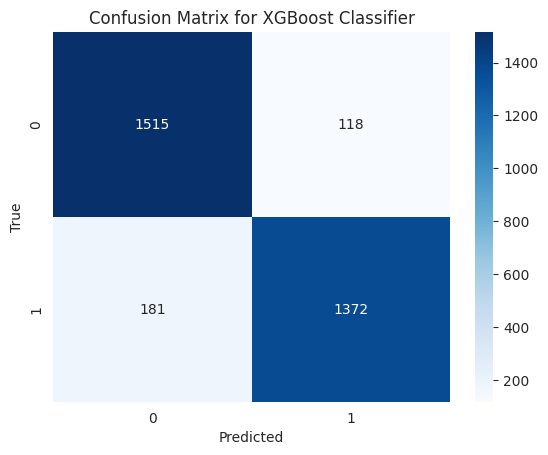

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# You can also visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()

## Neural Network

In [ ]:
# neural network model for prediction
# Define the neural network model

model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),


    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),


    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),


    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - Precision: 0.6167 - Recall: 0.6719 - accuracy: 0.6208 - loss: 0.6448 - val_Precision: 0.7122 - val_Recall: 0.7662 - val_accuracy: 0.7300 - val_loss: 0.5420
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - Precision: 0.7251 - Recall: 0.7248 - accuracy: 0.7211 - loss: 0.5594 - val_Precision: 0.7517 - val_Recall: 0.7773 - val_accuracy: 0.7618 - val_loss: 0.4808
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Precision: 0.7567 - Recall: 0.7714 - accuracy: 0.7592 - loss: 0.4959 - val_Precision: 0.7616 - val_Recall: 0.7923 - val_accuracy: 0.7735 - val_loss: 0.4585
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Precision: 0.7657 - Recall: 0.7722 - accuracy: 0.7641 - loss: 0.4900 - val_Precision: 0.7888 - val_Recall: 0.7757 - val_accuracy: 0.7853 - val_loss: 0.4495
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Precision: 0.7772 - Recall: 0.7862 - accuracy: 0.7784 - loss: 0.4644 - val_Precision: 0.7958 - val_Recall:

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 140,549 (549.02 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 93,700 (366.02 KB)

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred1 = (y_pred_prob > 0.5).astype(int)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.7868 - Recall: 0.8717 - accuracy: 0.8219 - loss: 0.3852
Test Loss: 0.3751
Test Accuracy: 0.8340
Test Precision: 0.8048
Test Recall: 0.8706
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
print("-----------------------------------------------------------------------------------")
print(f"First 10 values of y_test: {y_test.tolist()[29:40]}")
print(f"First 10 values of y_pred: {y_pred1.tolist()[29:40]}")

-----------------------------------------------------------------------------------
First 10 values of y_test: [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0]
First 10 values of y_pred: [[1], [1], [1], [0], [0], [1], [1], [0], [1], [0], [0]]


Confusion Matrix:
[[1305  328]
 [ 201 1352]]


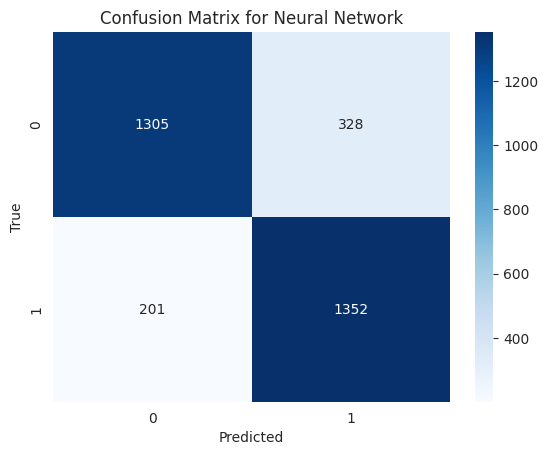

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred1)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# You can also visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Neural Network')
plt.show()

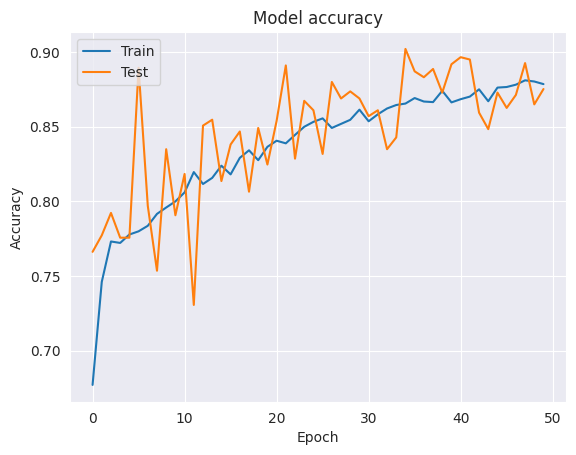

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['Recall'])
plt.plot(history.history['val_Recall'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()